In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.activations import relu
from keras.optimizers import Adam
from keras.losses import mse

np.random.seed(14)

Using TensorFlow backend.


# Create time series data

Generate a simple sine wave.

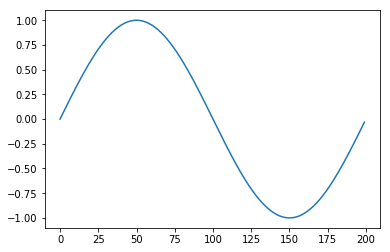

In [2]:
# hyper params for tuning
# max_samples % slice_size must == 0
slice_size = 125
max_samples=1000000
step = 0.01
epochs = 5

upper = max_samples * step
xs = np.arange(0, upper, step)
wave = np.sin(xs * np.pi)

plt.plot(wave[:200])

# Batch data

Reshape data to be in a form LSTM expects. (samples, timesteps, features)

Here samples just all the training data.  

Timesteps is the slice of time we will be feeding into the lstm. In this example we will take a slice of 125 from the time series. We will use this to predict the 126th item.

Features is the actual data points. In this case it is the y value (the amplitude at a given x value).

## Reshape

The wave data starts as:
[0, 1, 0, -1, 0, 1, 0, -1, 0,....]

In the below example we are batching into groups of 3 with 1 feature (samples, 3, 1). In the real code we will be doing 125 (samples, 125, 1).

```
[
  [[0], [1], [0]],
  [[-1], [0], [1]],
  [[0], [-1], [0]],
  ...
]```


If say we were running this with multiple features, like the close price and volume of ochl candles it would need to be shaped into (samples, 3, 2)

```
[
  [[500, 20], [505, 25], [510, 19]],
  [[508, 18], [505, 22], [510, 20]],
  [[515, 21], [513, 20], [520, 30]],
  ...
]```

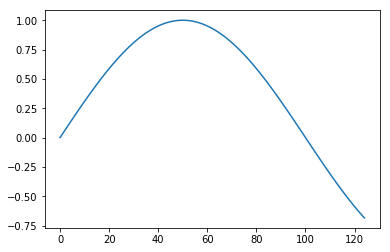

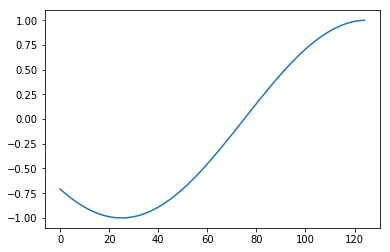

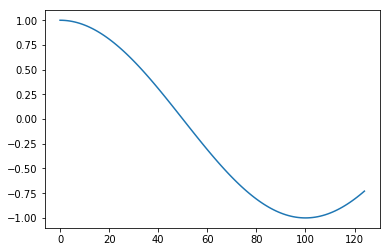

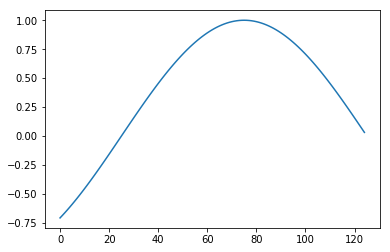

In [3]:
def get_batches(arr: np.array, sample_size: int):
    arr_len = len(arr)

    # end shape width * height must == len(original)
    assert arr_len % sample_size == 0, \
        "batch must evently divide into array length"

    arr = arr.reshape(int(arr_len / sample_size), sample_size, 1)
    return arr

# each item in x is a slice of time
X = get_batches(wave, slice_size)
plt.plot(X[0])
plt.show()
plt.plot(X[1])
plt.show()
plt.plot(X[2])
plt.show()
plt.plot(X[3])
plt.show()

# Get labels

Next we will get the labels to associate with each slice. This label can be taken from the first element of the next slice as that is the next item in the original series.

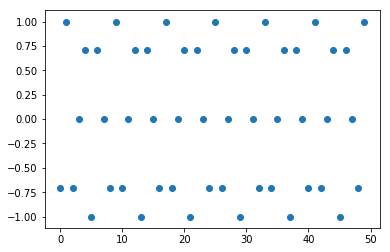

In [4]:
def get_labels(batches):
    labels = []
    for i, _ in enumerate(batches):
        if i == len(batches) - 1:
            continue
        labels.append(batches[i+1][0])
    return np.array(labels)

Y = get_labels(X)

# because we get Y from the next X
# we dont have label for last slice
X = X[:-1]

assert len(X) == len(Y)

plt.scatter(range(0,50), Y[:50])

# Possible issue

Looking at this makes me think our sample slices end up repeating themselves. I am curious if this will cause us to learn only these N unique samples and not be able to generalize to a sample outside of the learned set.

# Build and Fit

In [5]:
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(25, activation=relu))
model.add(Dropout(.25))
model.add(Dense(1))

model.compile(optimizer=Adam(), loss=mse)
model.fit(X, Y, epochs=epochs, validation_split=0.2)

Train on 6399 samples, validate on 1600 samples
Epoch 1/5
6399/6399 [==============================] - 23s 4ms/step - loss: 0.0537 - val_loss: 7.6151e-04
Epoch 2/5
6399/6399 [==============================] - 25s 4ms/step - loss: 0.0174 - val_loss: 0.0022
Epoch 3/5
6399/6399 [==============================] - 26s 4ms/step - loss: 0.0160 - val_loss: 5.5815e-04
Epoch 4/5
6399/6399 [==============================] - 23s 4ms/step - loss: 0.0165 - val_loss: 0.0021
Epoch 5/5
6399/6399 [==============================] - 23s 4ms/step - loss: 0.0160 - val_loss: 1.6847e-04


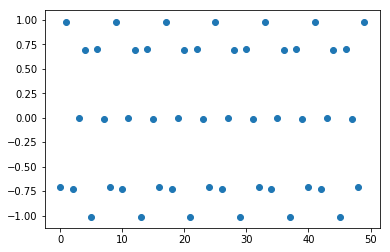

In [6]:
test = model.predict(X)
plt.scatter(range(0, 50), test[:50])

# Fit

It looks like we did indeed fit the training data. Now lets try a slice of time not in the original unique sets. We can see the below slice ends around -0.187 with the next step being -0.157. This answer is no where in the above well fitted test plot.

-0.18738131458572468
-0.15643446504023112


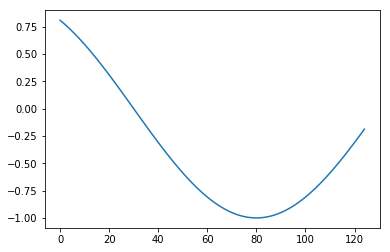

In [7]:
random_start_time = 70
test = wave[random_start_time:random_start_time + slice_size]
answer = wave[random_start_time + slice_size]

print(test[-1]) # last item in slice
print(answer) # next item after slice

plt.plot(test)

In [8]:
test = test.reshape(1, slice_size, 1)

pred = model.predict(test)
print(pred)
print(answer)
delta = answer - pred[0][0]
print(delta)

[[-0.19520664]]
-0.15643446504023112
0.03877217711064779


Off by quite a bit compaired to a well fit sample

In [9]:
pred = model.predict(np.array([X[0]]))
answer = Y[0]
print(pred)
print(answer)
delta = answer - pred[0][0]
print(delta)

[[-0.7118997]]
[-0.70710678]
[0.00479292]


# 1 Step Predications

Lets plot the predictions over the wave. We will take slices from each timestep. So first slice will be 0:125 next will be 1:126 and so on.

(1000, 125, 1)


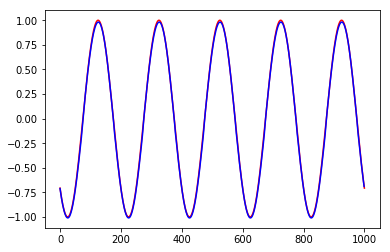

In [16]:
tests = []
labels = []
sample_size = 1000
for i, w in enumerate(wave):
    if i >= max_samples:
        continue
        
    w_slice = wave[i:i + slice_size]
    tests.append(w_slice)
    labels.append(wave[i + slice_size])

tests = np.array(tests)
tests = np.array(tests).reshape(tests.shape[0], tests.shape[1], 1)
print(tests.shape)

preds = model.predict(tests)
p = []
for i, pred in enumerate(preds):
    p.append(pred[0])

start = slice_size + 1 # need +1 because prediction starts there
end = sample_size + start
plt.plot(wave[slice_size:end], color='r')
plt.plot(p, color='b')

# Plot Error

Lets plot the error over the wave. We will take slices from each timestep. So first slice will be 0:125 next will be 1:126 and so on.

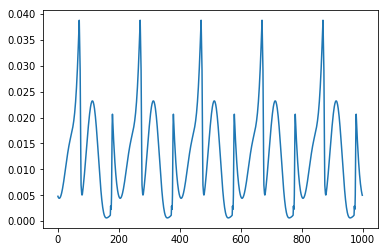

In [11]:
deltas = []

for i, pred in enumerate(preds):
    p = pred[0]
    deltas.append(labels[i] - p)
    
plt.plot(deltas)

# Compounding Error

Lets plot the wave again. This time we will take the output from the network and append it to the slices as we go along. The network will then be making predictions using its past predictions as input. We should be able to see if the error compounds if the output ends up looking nothing like a sine wave.

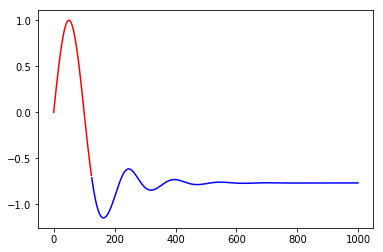

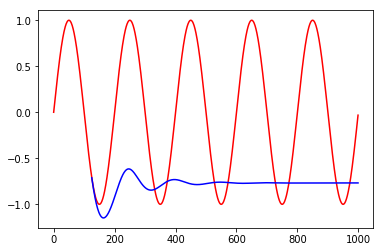

In [20]:
start = wave[0:slice_size]
current_test = list(start)
preds = []

total = sample_size - slice_size
for i in range(total):
    pred = model.predict(np.array(current_test).reshape(1, slice_size, 1))
    p = pred[0][0]
    current_test = current_test[1:]
    current_test.append(p)
    preds.append(p)
    
plt.plot(start, color='r')
plt.plot(range(slice_size, sample_size), preds, color='b')
plt.show()

plt.plot(wave[:sample_size], color='r')
plt.plot(range(slice_size, sample_size), preds, color='b')
plt.show()

Definitly not ideal over a long period of time. Lets try a slice closer to the turn, and one after the turn

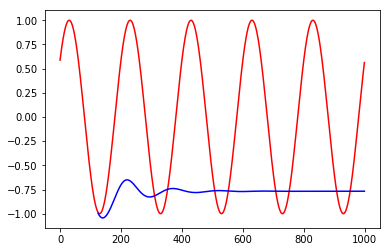

In [18]:
offselt = 20
start = wave[offselt:slice_size + offselt]
current_test = list(start)
preds = []

total = sample_size - slice_size
for i in range(total):
    pred = model.predict(np.array(current_test).reshape(1, slice_size, 1))
    p = pred[0][0]
    current_test = current_test[1:]
    current_test.append(p)
    preds.append(p)

plt.plot(wave[offselt:offselt + sample_size], color='r')
plt.plot(range(slice_size, sample_size), preds, color='b')
plt.show()

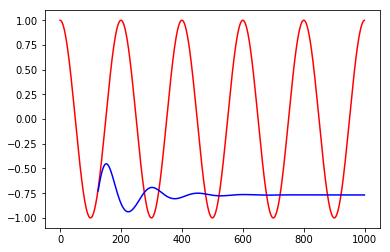

In [19]:
offselt = 50
start = wave[offselt:slice_size + offselt]
current_test = list(start)
preds = []

total = sample_size - slice_size
for i in range(total):
    pred = model.predict(np.array(current_test).reshape(1, slice_size, 1))
    p = pred[0][0]
    current_test = current_test[1:]
    current_test.append(p)
    preds.append(p)
    
plt.plot(wave[offselt:offselt + sample_size], color='r')
plt.plot(range(slice_size, sample_size), preds, color='b')
plt.show()

# Results

This turned out pretty well. When I saw the issue with the training data slices being repeated I thought for sure it would not generalize to slices not starting and ending in the same place as the training data. I think this did happen somewhat and is shown in the error plot above, but overall the predictions overlap the actual wave fairly well. You can see the red peaking out just a bit at the upper and lower limits of the amplitude on the 1 step predictions chart. As for compounding error it looks like it can only go 20ish steps before the model gets confused.